# Titanic Disaster

## Author: Nicolas Hernandez Zapata

### Description
Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Model Exploration

In [1]:
import numpy as np 
import pandas as pd 
from catboost import CatBoostClassifier, Pool
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


#### CatboostClassifier

CatBoostClassifier is a machine learning algorithm based on gradient boosting over decision trees, specifically optimized for categorical features. It is known for its ease of use, high performance, and unique handling of categorical data without requiring extensive preprocessing.

* CatBoost builds an ensemble of decision trees sequentially. Each tree attempts to correct the errors of the previous trees by minimizing a loss function.
* CatBoost uses symmetric decision trees, where all splits at the same depth level are the same across all branches. This structure reduces overfitting and speeds up prediction times.
* CatBoost uses ordered boosting, which involves creating random permutations of the data and training each decision tree on only the data points seen before the current observation in the permutation, reducing overfitting and improving model robustness
##### When to use
* Datasets with Many Categorical Features
* To get fast training times

In [2]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
train_cat = train[["Survived", "Pclass", "Sex", "Embarked"]].copy()
#Embarked has 2 missing values so let's drop them
train_cat.dropna(inplace = True)
print("Lenght train_cat:", len(train_cat))
X_cat = train_cat.drop('Survived', axis=1)
y_cat = train_cat['Survived']
X_train, X_temp, y_train, y_temp = train_test_split(X_cat, y_cat, test_size=0.3, random_state=42) #Separate train set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) #Create validation and test set

Lenght train_cat: 889


In [3]:
cat_features =["Sex", "Embarked"]
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)
#Pool is a data container that contains the training dataset, 
#along with optionally the target variable and details about the categorical features
cat_model = CatBoostClassifier(eval_metric='Accuracy',
                               random_seed=42,
                               cat_features=cat_features,
                               verbose=10,
                               early_stopping_rounds=50
                              )
cat_model.fit(train_pool, eval_set=val_pool, verbose=True)

Learning rate set to 0.028182
0:	learn: 0.7845659	test: 0.7819549	best: 0.7819549 (0)	total: 55.1ms	remaining: 55.1s
1:	learn: 0.7845659	test: 0.7819549	best: 0.7819549 (0)	total: 57.8ms	remaining: 28.9s
2:	learn: 0.7845659	test: 0.7819549	best: 0.7819549 (0)	total: 59.7ms	remaining: 19.8s
3:	learn: 0.7845659	test: 0.7819549	best: 0.7819549 (0)	total: 61.2ms	remaining: 15.2s
4:	learn: 0.7845659	test: 0.7819549	best: 0.7819549 (0)	total: 63ms	remaining: 12.5s
5:	learn: 0.8135048	test: 0.8120301	best: 0.8120301 (5)	total: 65.1ms	remaining: 10.8s
6:	learn: 0.8135048	test: 0.8120301	best: 0.8120301 (5)	total: 68ms	remaining: 9.64s
7:	learn: 0.8135048	test: 0.8120301	best: 0.8120301 (5)	total: 70.7ms	remaining: 8.76s
8:	learn: 0.8135048	test: 0.8120301	best: 0.8120301 (5)	total: 72.2ms	remaining: 7.95s
9:	learn: 0.8135048	test: 0.8120301	best: 0.8120301 (5)	total: 73.5ms	remaining: 7.28s
10:	learn: 0.8135048	test: 0.8120301	best: 0.8120301 (5)	total: 74.9ms	remaining: 6.73s
11:	learn: 0.813

In [4]:
y_pred = cat_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85        81
           1       0.86      0.58      0.70        53

    accuracy                           0.80       134
   macro avg       0.82      0.76      0.77       134
weighted avg       0.81      0.80      0.79       134



In [5]:
feature_importance  = cat_model.get_feature_importance(prettified=True)
print(feature_importance)

  Feature Id  Importances
0        Sex    72.027809
1     Pclass    25.946013
2   Embarked     2.026178


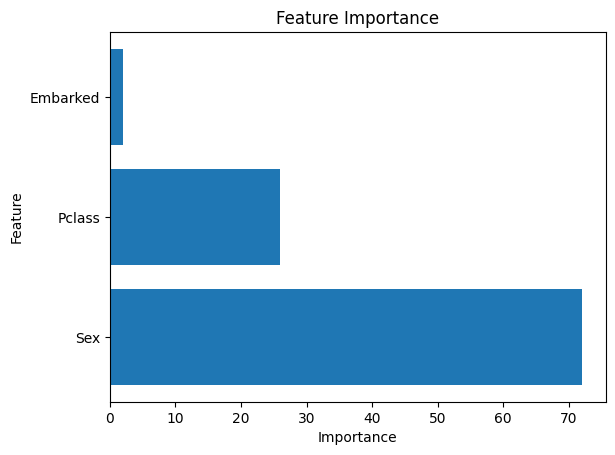

In [6]:
plt.barh(feature_importance['Feature Id'], feature_importance['Importances'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

From this attempt we can conclude that the embarked feature is not relevant to the model. On the contrary Pclass shows some relevance in the decision making. In the next models we won't include the embarked feature.

#### CatBoostModel

In this model all variables will be taken into account. We won´t include the embarked feature due to it's lack of relevance. Age won't be included due to the missing values.

In [7]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
train_cat_2 = train[["Survived", "Pclass", "Sex", "SibSp", "Parch", "Fare"]].copy()
print("Lenght train_cat:", len(train_cat_2))
X_cat_2 = train_cat_2.drop('Survived', axis=1)
y_cat_2 = train_cat_2['Survived']
X_train_cat_2, X_temp_cat_2, y_train_cat_2, y_temp_cat_2 = train_test_split(X_cat_2, y_cat_2, test_size=0.3, random_state=42) #Separate train set
X_val_cat_2, X_test_cat_2, y_val_cat_2, y_test_cat_2 = train_test_split(X_temp_cat_2, y_temp_cat_2, test_size=0.5, random_state=42) #Create validation and test set

Lenght train_cat: 891


In [8]:
cat_features =["Sex"]
train_pool_cat_2 = Pool(data=X_train_cat_2, label=y_train_cat_2, cat_features=cat_features)
val_pool_cat_2 = Pool(data=X_val_cat_2, label=y_val_cat_2, cat_features=cat_features)
#Pool is a data container that contains the training dataset, 
#along with optionally the target variable and details about the categorical features
cat_model_2 = CatBoostClassifier(eval_metric='Accuracy',
                               random_seed=42,
                               cat_features=cat_features,
                               verbose=50,
                               early_stopping_rounds=50
                              )
cat_model_2.fit(train_pool_cat_2, eval_set=val_pool_cat_2, verbose=True)

Learning rate set to 0.028193
0:	learn: 0.7849117	test: 0.8059701	best: 0.8059701 (0)	total: 1.07ms	remaining: 1.07s
1:	learn: 0.8041734	test: 0.8208955	best: 0.8208955 (1)	total: 2.8ms	remaining: 1.4s
2:	learn: 0.8073836	test: 0.8283582	best: 0.8283582 (2)	total: 3.97ms	remaining: 1.32s
3:	learn: 0.8073836	test: 0.8283582	best: 0.8283582 (2)	total: 4.85ms	remaining: 1.21s
4:	learn: 0.8073836	test: 0.8283582	best: 0.8283582 (2)	total: 6.16ms	remaining: 1.23s
5:	learn: 0.8089888	test: 0.8208955	best: 0.8283582 (2)	total: 7.43ms	remaining: 1.23s
6:	learn: 0.8057785	test: 0.8208955	best: 0.8283582 (2)	total: 8.81ms	remaining: 1.25s
7:	learn: 0.8057785	test: 0.8208955	best: 0.8283582 (2)	total: 10.1ms	remaining: 1.25s
8:	learn: 0.8105939	test: 0.8208955	best: 0.8283582 (2)	total: 11.3ms	remaining: 1.24s
9:	learn: 0.8121990	test: 0.8208955	best: 0.8283582 (2)	total: 12.3ms	remaining: 1.22s
10:	learn: 0.8121990	test: 0.8208955	best: 0.8283582 (2)	total: 13.6ms	remaining: 1.22s
11:	learn: 0.8

In [9]:
y_pred_cat_2 = cat_model_2.predict(X_test_cat_2)
print(classification_report(y_test_cat_2, y_pred_cat_2))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85        87
           1       0.74      0.66      0.70        47

    accuracy                           0.80       134
   macro avg       0.78      0.77      0.77       134
weighted avg       0.80      0.80      0.80       134



  Feature Id  Importances
0        Sex    73.839235
1     Pclass    20.981651
2       Fare     1.797719
3      SibSp     1.755459
4      Parch     1.625936


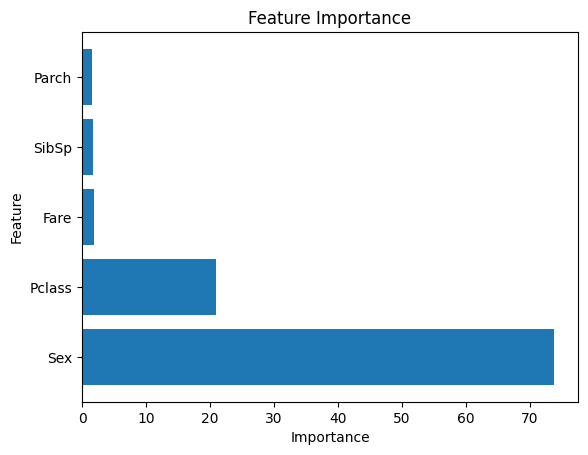

In [10]:
feature_importance  = cat_model_2.get_feature_importance(prettified=True)
print(feature_importance)

plt.barh(feature_importance['Feature Id'], feature_importance['Importances'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

The results improve in the validation set, but in the test set, the results were the same in terms of accuracy.

As the previous model, Sex and Pclass are the most important features. The rest of the features are not relevant and as the results don't change in a significant way it's possible to remove them.

In the next model the age will be added in two ways, removing the missing fields and imputating the missing fields.

#### CatboostClassifier dropping age

In [11]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
train_cat_3 = train[["Survived", "Pclass", "Sex","Age", "SibSp", "Parch", "Fare", "Embarked"]].copy()
train_cat_3.dropna(inplace = True)
print("Lenght train_cat:", len(train_cat_3))
X_cat_3 = train_cat_3.drop('Survived', axis=1)
y_cat_3 = train_cat_3['Survived']
X_train_cat_3, X_temp_cat_3, y_train_cat_3, y_temp_cat_3 = train_test_split(X_cat_3, y_cat_3, test_size=0.3, random_state=42) #Separate train set
X_val_cat_3, X_test_cat_3, y_val_cat_3, y_test_cat_3 = train_test_split(X_temp_cat_3, y_temp_cat_3, test_size=0.5, random_state=42) #Create validation and test set

Lenght train_cat: 712


In [12]:
cat_features =["Sex", "Embarked"]
train_pool_cat_3 = Pool(data=X_train_cat_3, label=y_train_cat_3, cat_features=cat_features)
val_pool_cat_3 = Pool(data=X_val_cat_3, label=y_val_cat_3, cat_features=cat_features)
#Pool is a data container that contains the training dataset, 
#along with optionally the target variable and details about the categorical features
cat_model_3 = CatBoostClassifier(eval_metric='Accuracy',
                               random_seed=42,
                               cat_features=cat_features,
                               verbose=50,
                               early_stopping_rounds=50
                              )
cat_model_3.fit(train_pool_cat_3, eval_set=val_pool_cat_3, verbose=True)

Learning rate set to 0.026676
0:	learn: 0.8052209	test: 0.7476636	best: 0.7476636 (0)	total: 1.71ms	remaining: 1.7s
1:	learn: 0.8232932	test: 0.7663551	best: 0.7663551 (1)	total: 4.68ms	remaining: 2.34s
2:	learn: 0.8212851	test: 0.7663551	best: 0.7663551 (1)	total: 6.91ms	remaining: 2.3s
3:	learn: 0.8232932	test: 0.7757009	best: 0.7757009 (3)	total: 9.12ms	remaining: 2.27s
4:	learn: 0.8212851	test: 0.7850467	best: 0.7850467 (4)	total: 11.6ms	remaining: 2.31s
5:	learn: 0.8212851	test: 0.7850467	best: 0.7850467 (4)	total: 14.1ms	remaining: 2.34s
6:	learn: 0.8152610	test: 0.7663551	best: 0.7850467 (4)	total: 15.7ms	remaining: 2.23s
7:	learn: 0.8192771	test: 0.7850467	best: 0.7850467 (4)	total: 17.5ms	remaining: 2.17s
8:	learn: 0.8232932	test: 0.7850467	best: 0.7850467 (4)	total: 19.7ms	remaining: 2.16s
9:	learn: 0.8232932	test: 0.7850467	best: 0.7850467 (4)	total: 21.4ms	remaining: 2.12s
10:	learn: 0.8212851	test: 0.7850467	best: 0.7850467 (4)	total: 23.7ms	remaining: 2.13s
11:	learn: 0.8

In [13]:
y_pred_cat_3 = cat_model_3.predict(X_test_cat_3)
print(classification_report(y_test_cat_3, y_pred_cat_3))

              precision    recall  f1-score   support

           0       0.74      0.88      0.80        57
           1       0.82      0.64      0.72        50

    accuracy                           0.77       107
   macro avg       0.78      0.76      0.76       107
weighted avg       0.78      0.77      0.76       107



  Feature Id  Importances
0        Sex    56.051073
1     Pclass    22.839379
2        Age     8.281283
3       Fare     7.673574
4      SibSp     3.314718
5   Embarked     1.229313
6      Parch     0.610660


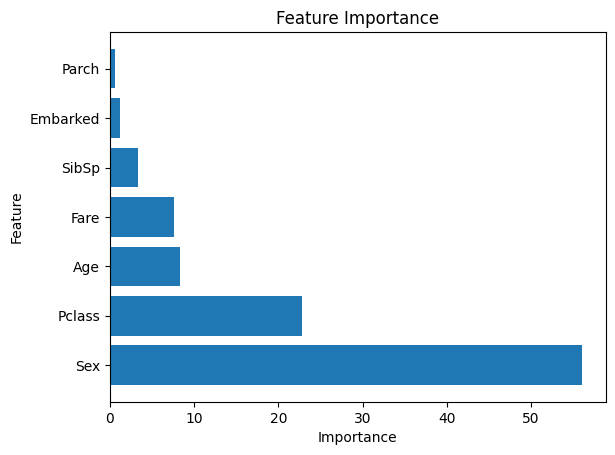

In [14]:
feature_importance  = cat_model_3.get_feature_importance(prettified=True)
print(feature_importance)

plt.barh(feature_importance['Feature Id'], feature_importance['Importances'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In this test, it's observed that the age is the third variable in terms of importance. This shows that the age must be included in the model.

#### CatboostClassifier imputing age with the mean

In [15]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
train_cat_4 = train[["Survived", "Pclass", "Sex","Age", "SibSp", "Parch", "Fare", "Embarked"]].copy()
train_cat_4["Age"].fillna(train_cat_4["Age"].mean(), inplace = True)
train_cat_4.dropna(inplace = True)
print("Lenght train_cat:", len(train_cat_4))
X_cat_4 = train_cat_4.drop('Survived', axis=1)
y_cat_4 = train_cat_4['Survived']
X_train_cat_4, X_temp_cat_4, y_train_cat_4, y_temp_cat_4 = train_test_split(X_cat_4, y_cat_4, test_size=0.3, random_state=42) #Separate train set
X_val_cat_4, X_test_cat_4, y_val_cat_4, y_test_cat_4 = train_test_split(X_temp_cat_4, y_temp_cat_4, test_size=0.5, random_state=42) #Create validation and test set

Lenght train_cat: 889


In [16]:
cat_features =["Sex", "Embarked"]
train_pool_cat_4 = Pool(data=X_train_cat_4, label=y_train_cat_4, cat_features=cat_features)
val_pool_cat_4 = Pool(data=X_val_cat_4, label=y_val_cat_4, cat_features=cat_features)
#Pool is a data container that contains the training dataset, 
#along with optionally the target variable and details about the categorical features
cat_model_4 = CatBoostClassifier(eval_metric='Accuracy',
                               random_seed=42,
                               cat_features=cat_features,
                               verbose=50,
                               early_stopping_rounds=50
                              )
cat_model_4.fit(train_pool_cat_4, eval_set=val_pool_cat_4, verbose=True)

Learning rate set to 0.028182
0:	learn: 0.7845659	test: 0.7819549	best: 0.7819549 (0)	total: 1.78ms	remaining: 1.78s
1:	learn: 0.8215434	test: 0.7819549	best: 0.7819549 (0)	total: 4.97ms	remaining: 2.48s
2:	learn: 0.8311897	test: 0.7969925	best: 0.7969925 (2)	total: 7.25ms	remaining: 2.41s
3:	learn: 0.8376206	test: 0.7969925	best: 0.7969925 (2)	total: 9.53ms	remaining: 2.37s
4:	learn: 0.8086817	test: 0.7894737	best: 0.7969925 (2)	total: 10.9ms	remaining: 2.17s
5:	learn: 0.8006431	test: 0.7894737	best: 0.7969925 (2)	total: 12.4ms	remaining: 2.06s
6:	learn: 0.8006431	test: 0.7969925	best: 0.7969925 (2)	total: 14.5ms	remaining: 2.06s
7:	learn: 0.8006431	test: 0.8045113	best: 0.8045113 (7)	total: 16.4ms	remaining: 2.03s
8:	learn: 0.7974277	test: 0.7969925	best: 0.8045113 (7)	total: 17.8ms	remaining: 1.96s
9:	learn: 0.8006431	test: 0.7969925	best: 0.8045113 (7)	total: 19.8ms	remaining: 1.96s
10:	learn: 0.8086817	test: 0.8045113	best: 0.8045113 (7)	total: 22.4ms	remaining: 2.01s
11:	learn: 0

In [17]:
y_pred_cat_4 = cat_model_4.predict(X_test_cat_4)
print(classification_report(y_test_cat_4, y_pred_cat_4))

              precision    recall  f1-score   support

           0       0.80      0.91      0.86        81
           1       0.83      0.66      0.74        53

    accuracy                           0.81       134
   macro avg       0.82      0.79      0.80       134
weighted avg       0.82      0.81      0.81       134



  Feature Id  Importances
0        Sex    55.184624
1     Pclass    20.907766
2        Age     8.610400
3   Embarked     4.734492
4       Fare     4.370425
5      SibSp     4.148643
6      Parch     2.043649


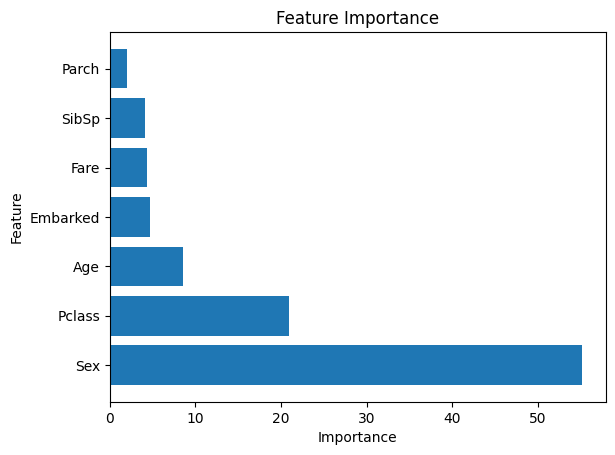

In [18]:
feature_importance  = cat_model_4.get_feature_importance(prettified=True)
print(feature_importance)

plt.barh(feature_importance['Feature Id'], feature_importance['Importances'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

When the age is imputed the embarked features becomes the fourth most important variable. Also in general, the imputation of the age improves the model.

**Note:** Other imputation techniques could be used, like using a gradientboosting model to predict age in the missing values. This technique woul be good, easy to train and computationally effective. Nevertheless, for the sake of learning, a GEN AI imputation technique would be explore.

#### CatboostClassifier using GEN AI imputation techniques

Two imputation techniques were considered. The first one considered is using GANs but as the data set is small, we avoid this method in order to prevent overfitting. The second technique are flow based models like variational autoencoders (VAEs). VAEs tend to work best with small datasets and are easier to train than GANs. For those reason VAEs will be used in this part of the code. 

In [19]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [20]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
train_cat_5 = train[["Survived", "Pclass", "Sex","Age", "SibSp", "Parch", "Fare", "Embarked"]].copy()
train_cat_5.dropna(subset = ["Embarked"], inplace = True)
print("Lenght train_cat:", len(train_cat_5))
#Loop through categorical columns and apply LabelEncoder to convert them into numerical values.
for col in train_cat_5.select_dtypes(include='object').columns:
    train_cat_5[col] = LabelEncoder().fit_transform(train_cat_5[col])
train_cat_5_original = train_cat_5
train_cat_5 = train_cat_5.drop('Survived', axis=1)

Lenght train_cat: 889


In [21]:
class VAE(nn.Module):
    #Defines a class VAE that inherits from torch.nn.Module, which is the base class for all neural network models in PyTorch.
    def __init__(self, input_dim, hidden_dim, latent_dim): #three dimensions, The number of features, the size of the hidden layer, The size of the latent (bottleneck) layer.
        super(VAE, self).__init__()
        self.encoder = nn.Sequential( #A sequential stack of layers that forms the encoder part of the VAE. It maps the input data to a compressed latent space.
            nn.Linear(input_dim, hidden_dim), #A linear transformation from the input layer to a hidden layer with hidden_dim neurons.
            nn.ReLU(), #Applies a Rectified Linear Unit (ReLU) activation function to introduce non-linearity.
            nn.Linear(hidden_dim, latent_dim) #A linear transformation from the hidden layer to the latent (bottleneck) layer.
        )
        self.decoder = nn.Sequential(#A sequential stack of layers that forms the decoder part of the VAE. It reconstructs the input from the latent representation.
            nn.Linear(latent_dim, hidden_dim), #A linear transformation from the latent layer to a hidden layer.
            nn.ReLU(), #Applies a ReLU activation for non-linearity.
            nn.Linear(hidden_dim, input_dim) #A linear transformation from the hidden layer to the output layer, reconstructing the original input.
        )

    def forward(self, x): #Defines how data flows through the model during a forward pass.
        z = self.encoder(x) #Encodes the input x into the latent representation z.
        x_reconstructed = self.decoder(z) #Decodes the latent representation z back into the reconstructed input.
        return x_reconstructed

In [22]:
temp_imputed = train_cat_5.copy()
temp_imputed["Age"] = train_cat_5["Age"].fillna(train_cat_5["Age"].mean())
scaler = StandardScaler()
scaled_data = scaler.fit_transform(temp_imputed)

# Define VAE parameters
input_dim = scaled_data.shape[1]
hidden_dim = 64
latent_dim = 32
vae = VAE(input_dim, hidden_dim, latent_dim)

#Train the VAE
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_data, _ = train_test_split(scaled_data, test_size=0.2, random_state=42)
train_data = torch.tensor(train_data, dtype=torch.float32) #Data to tensor format

In [23]:
epochs = 100
for epoch in range(epochs):
    vae.train() #Sets the model to training mode.
    outputs = vae(train_data) #Passes the input through the VAE to get reconstructed outputs.
    loss = criterion(outputs, train_data) #Calculates the reconstruction loss between original and reconstructed data
    optimizer.zero_grad() #Resets gradients to zero before backpropagation.
    loss.backward() #Computes gradients of the loss with respect to model parameters.
    optimizer.step() #Updates the model parameters using the computed gradients.

In [24]:
vae.eval()
reconstructed_data = vae(torch.tensor(scaled_data, dtype=torch.float32)).detach().numpy()

# Replace NaN values in the original numerical column
reconstructed_unscaled = scaler.inverse_transform(reconstructed_data)
imputed_indices = train_cat_5_original[train_cat_5_original["Age"].isnull()].index
train_cat_5_original["Age"] = np.where(train_cat_5_original["Age"].isnull(), reconstructed_unscaled[:, 2], train_cat_5_original["Age"])
train_cat_5_original.head(6)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.000000,1,0,7.2500,2
1,1,1,0,38.000000,1,0,71.2833,0
2,1,3,0,26.000000,0,0,7.9250,2
3,1,1,0,35.000000,1,0,53.1000,2
4,0,3,1,35.000000,0,0,8.0500,2
5,0,3,1,31.019506,0,0,8.4583,1


In [25]:
print("Lenght train_cat:", len(train_cat_5_original))
X_cat_5 = train_cat_5_original.drop('Survived', axis=1)
y_cat_5 = train_cat_5_original['Survived']
X_train_cat_5, X_temp_cat_5, y_train_cat_5, y_temp_cat_5 = train_test_split(X_cat_5, y_cat_5, test_size=0.3, random_state=42) #Separate train set
X_val_cat_5, X_test_cat_5, y_val_cat_5, y_test_cat_5 = train_test_split(X_temp_cat_5, y_temp_cat_5, test_size=0.5, random_state=42) #Create validation and test set

Lenght train_cat: 889


In [26]:
train_pool_cat_5 = Pool(data=X_train_cat_5, label=y_train_cat_5)
val_pool_cat_5 = Pool(data=X_val_cat_5, label=y_val_cat_5)
#Pool is a data container that contains the training dataset, 
#along with optionally the target variable and details about the categorical features
cat_model_5 = CatBoostClassifier(eval_metric='Accuracy',
                               random_seed=42,
                               verbose=50,
                               early_stopping_rounds=50
                              )
cat_model_5.fit(train_pool_cat_5, eval_set=val_pool_cat_5, verbose=True)

Learning rate set to 0.028182
0:	learn: 0.8135048	test: 0.8120301	best: 0.8120301 (0)	total: 1.21ms	remaining: 1.21s
1:	learn: 0.8279743	test: 0.8045113	best: 0.8120301 (0)	total: 2.67ms	remaining: 1.33s
2:	learn: 0.8086817	test: 0.8045113	best: 0.8120301 (0)	total: 3.65ms	remaining: 1.21s
3:	learn: 0.8167203	test: 0.8120301	best: 0.8120301 (0)	total: 5.09ms	remaining: 1.27s
4:	learn: 0.8279743	test: 0.8120301	best: 0.8120301 (0)	total: 6.41ms	remaining: 1.27s
5:	learn: 0.8295820	test: 0.8195489	best: 0.8195489 (5)	total: 7.79ms	remaining: 1.29s
6:	learn: 0.8279743	test: 0.8195489	best: 0.8195489 (5)	total: 9.37ms	remaining: 1.33s
7:	learn: 0.8295820	test: 0.8120301	best: 0.8195489 (5)	total: 10.8ms	remaining: 1.33s
8:	learn: 0.8311897	test: 0.8120301	best: 0.8195489 (5)	total: 11.7ms	remaining: 1.29s
9:	learn: 0.8295820	test: 0.8195489	best: 0.8195489 (5)	total: 12.9ms	remaining: 1.27s
10:	learn: 0.8231511	test: 0.8195489	best: 0.8195489 (5)	total: 14.1ms	remaining: 1.27s
11:	learn: 0

In [27]:
y_pred_cat_5 = cat_model_5.predict(X_test_cat_5)
print(classification_report(y_test_cat_5, y_pred_cat_5))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86        81
           1       0.85      0.64      0.73        53

    accuracy                           0.81       134
   macro avg       0.82      0.78      0.79       134
weighted avg       0.82      0.81      0.81       134



  Feature Id  Importances
0        Sex    42.603817
1     Pclass    17.476805
2        Age    14.044412
3       Fare     9.925620
4      SibSp     7.235826
5   Embarked     5.491119
6      Parch     3.222400


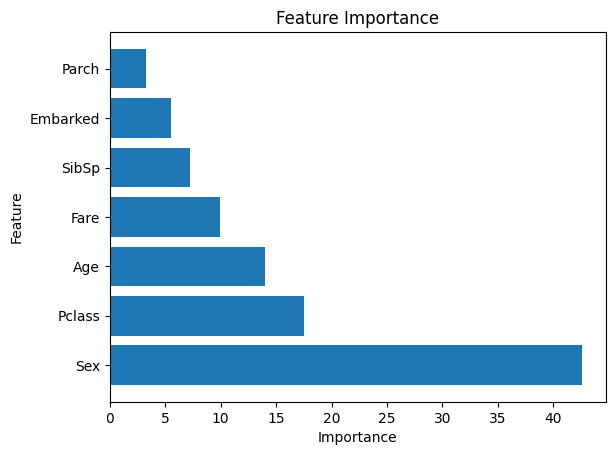

In [28]:
feature_importance  = cat_model_5.get_feature_importance(prettified=True)
print(feature_importance)

plt.barh(feature_importance['Feature Id'], feature_importance['Importances'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Estimated time: ~3 hours

In [50]:
test = pd.read_csv("/kaggle/input/titanic/test.csv")
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [51]:
test["Fare"] = test["Fare"].fillna(test["Fare"].mean())
pred = test[["Pclass", "Sex","Age", "SibSp", "Parch", "Fare", "Embarked"]].copy()
for col in pred.select_dtypes(include='object').columns:
    pred[col] = LabelEncoder().fit_transform(pred[col])
pred_origin = pred.copy()
pred["Age"] = pred["Age"].fillna(pred["Age"].mean())
test_scaled_data = scaler.fit_transform(pred)
vae.eval()
reconstructed_data = vae(torch.tensor(test_scaled_data, dtype=torch.float32)).detach().numpy()
reconstructed_unscaled = scaler.inverse_transform(reconstructed_data)
pred_origin["Age"] = np.where(pred_origin["Age"].isnull(), reconstructed_unscaled[:, 2], pred_origin["Age"])
pred_origin.tail(6)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
412,3,0,28.000000,0,0,7.7750,2
413,3,1,30.294847,0,0,8.0500,2
414,1,0,39.000000,0,0,108.9000,0
415,3,1,38.500000,0,0,7.2500,2
416,3,1,30.294847,0,0,8.0500,2
417,3,1,28.446804,1,1,22.3583,0


In [52]:
submission_pred = cat_model_5.predict(pred_origin)
test['Survived'] = submission_pred
submission = test.filter(items={'PassengerId', 'Survived'})

In [56]:
submission.to_csv('submission.csv', index = False)